In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other
from datetime import datetime, timedelta

# Time Series - Data Processing

In [2]:
df = pd.read_csv('../data/prices_database.csv', index_col='Unnamed: 0', parse_dates=['added_date', 'date'])
df.head(2)

,player_name,quality,revision,overall,club,league,nationality,position,age,height,weight,intl_rep,added_date,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,drib_reactions,drib_ball_control,drib_dribbling,drib_composure,shooting,shoot_positioning,shoot_finishing,shoot_shot_power,shoot_long_shots,shoot_volleys,shoot_penalties,passing,pass_vision,pass_crossing,pass_free_kick,pass_short,pass_long,pass_curve,defending,def_interceptions,def_heading,def_marking,def_stand_tackle,def_slid_tackle,physicality,phys_jumping,phys_stamina,phys_strength,phys_aggression,pref_foot,att_workrate,def_workrate,weak_foot,skill_moves,resource_id,num_games,avg_goals,avg_assists,date,price
0,Pelé,Gold - Rare,Icon,98,Icons,Icons,Brazil,CAM,77,173,70,0,2018-09-19,95.0,95,95,96.0,94,93,98,97,96,98,96.0,97,98,94,94,95,93,93.0,97,90,89,96,88,89,60.0,67,94,55,53,49,76.0,88,86,76,59,Right,High,Med,4,5,237067,"140,067",0.58,0.38,2018-09-20,0
1,Pelé,Gold - Rare,Icon,98,Icons,Icons,Brazil,CAM,77,173,70,0,2018-09-19,95.0,95,95,96.0,94,93,98,97,96,98,96.0,97,98,94,94,95,93,93.0,97,90,89,96,88,89,60.0,67,94,55,53,49,76.0,88,86,76,59,Right,High,Med,4,5,237067,"140,067",0.58,0.38,2018-09-21,0


## Feature Engineering

We need to construct the following features:
- available: Binary variable indicating the availability of the card on that given day
- *substitute* (scratched for the time being): Binary variable indicating whether a new card for that player is available during that day. (SBC + Packs)
- days: # of days available
- general position: group the positions together
- promo: binary indicating if there's a promotion on that day. 
- weekday: 0-6 indicating the day of the week
- source: Whether the card was an SBC, Weekly OBJ or in packs.
- days_release: # of days since game release

**Days**:

In [3]:
df['days'] = (df['date'] - df['added_date']).dt.days

Quick to note that some players have prices for the day before they were officially released, implying there's a mistake. Further investigation reveals that these should be offset to the next day instead. 

In [4]:
offset_resources = df[df.days == -1].resource_id.unique()       # get resource id of users who match this 

df['date'] = np.where(df.resource_id.isin(offset_resources),    # remap the date variable
                      df.date +pd.DateOffset(days=1), df.date)
df['days'] = (df.date - df.added_date).dt.days                  # reassign the days variable

df = df[df.days >= 0]                                           # remove observations that have days < 0

**Weekday**:

In [5]:
df['weekday'] = df.date.dt.weekday                              # get the day of the week

**General Position**:

In [6]:
for_pos = ['ST', 'CF', 'CAM', 'LW', 'LF', 'LM', 'RW', 'RF', 'RM']
mid_pos = ['CM', 'CDM']
def_pos = ['LB', 'LWB', 'CB', 'RB', 'RWB']

df['gen_pos'] = np.where(df.position.isin(for_pos), 'forward', np.nan)
df['gen_pos'] = np.where(df.position.isin(mid_pos), 'midfielder', df.gen_pos)
df['gen_pos'] = np.where(df.position.isin(def_pos), 'defender', df.gen_pos)

**Club/League Group**:

In [7]:
df = df[df.club != 'Icons']  # drop icons

In [8]:
t_leagues = ['Premier League', 'Serie A TIM', 'LaLiga Santander', 'Ligue 1 Conforama', 'Bundesliga']
df['league'] = np.where(df.league.isin(t_leagues), 1, 0)

t_clubs = ['Manchester United', 'Manchester City', 'Chelsea', 'Liverpool', 'Arsenal', 'Tottenham Hotspur',
           'Paris Saint-Germain', 'Juventus', 'Napoli', 'Inter', 'FC Barcelona', 'Real Madrid', 'Atlético Madrid',
           'Borussia Dortmund', 'FC Bayern München']
df['club'] = np.where(df.club.isin(t_clubs), 1, 0)

t_nations = df.groupby(['nationality']).resource_id.nunique().reset_index().sort_values(by=['resource_id'], ascending=False)[:10].nationality.values
df['nationality'] = np.where(df.nationality.isin(t_nations), 1, 0)

**Promo**:

Promotional periods are the following:
- TOTS: 10/5-21/6
- Icon Release: 5/4-15/4
- Fut Bday: 22/3-30/3
- Carniball: 8/3-16/3
- Rating Refresh: 15/2-24/2
- Headliners: 1/2-8/2
- Future Stars: 18/1-25/1
- TOTY: 7/1-14/1
- Futmas: 14/12-24/12
- TOTGS: 7/12-14/12
- Black Friday: 23/11-26/11
- RTTF: 9/11-16/11
- Halloween: 19/10-26/10

In [9]:
promos = [[datetime(2019, 5, 10), datetime(2019, 6, 21)],       # TOTS
          [datetime(2019, 4, 5), datetime(2019, 4, 15)],        # icon release
          [datetime(2019, 3, 22), datetime(2019, 3, 30)],       # fut bday
          [datetime(2019, 3, 8), datetime(2019, 3, 16)],        # carniball
          [datetime(2019, 2, 15), datetime(2019, 2, 24)],       # rating refresh
          [datetime(2019, 2, 1), datetime(2019, 2, 8)],         # headliners
          [datetime(2019, 1, 18), datetime(2019, 1, 25)],       # ffs
          [datetime(2019, 1, 7), datetime(2019, 1, 14)],        # TOTY
          [datetime(2018, 12, 14), datetime(2018, 12, 24)],     # futmas
          [datetime(2018, 12, 7), datetime(2018, 12, 14)],      # totgs
          [datetime(2018, 11, 23), datetime(2018, 11, 26)],     # black friday
          [datetime(2018, 11, 9), datetime(2018, 11, 16)],      # rttf
          [datetime(2018, 10, 19), datetime(2018, 10, 26)]]     # halloween

def promo_assignment(ds):
    date = pd.to_datetime(ds)
    promo = 0
    for p in promos:
        if (p[0] <= date) & (p[1] >= date):
            promo = 1
            break
    return promo

df['promo'] = df['date'].apply(promo_assignment)                # apply the promo assignment

**Card Source**:

In [10]:
df.revision.fillna('MLS POTM', inplace=True)

In [11]:
df['source'] = 'packs'
df['source'] = np.where(df.revision.str.contains('Normal') | df.revision.str.contains('Icon') | df.revision.str.contains('Refresh'),
                        'base', df.source)                                                                     # Base cards
df['source'] = np.where(df.revision.str.contains('SBC') | df.revision.str.contains('POTM'), 'sbc', df.source)  # SBC
df['source'] = np.where(df.revision.str.contains('Loan'), 'loan', df.source)                                   # Loans
df['source'] = np.where(df.revision.str.contains('Ob'), 'objective', df.source)                                # Objectives

df = df[df.source != 'loan']                                                                                   # remove loan cards

**Availability**:
- Pack cards: will be labeled as available for a week after being added to the database. This isn't always accurate but an overall approximation.
- SBC: Availability will also be set for a week - again, an approximation. 
- Objectives: Weekly availability
- Winter Upgrades + Base Cards: Available throughout except periods where they have special cards in packs. Winter upgrades replace base cards. 

In [12]:
df['available'] = np.nan

# special cards in packs, sbcs and objectives
df['available'] = np.where(((df.source == 'packs') | (df.source == 'sbc') | (df.source == 'objective')) & (df.date <= df.added_date + pd.DateOffset(7)),
                           1, df.available)

In [13]:
# create a cross product to find the availability of base cards from special pack cards
base = df[df.source == 'base'][['player_name', 'age', 'height', 'weight', 'intl_rep', 'date', 'added_date', 'available', 'resource_id']]
pack = df[df.source == 'packs'][['player_name', 'age', 'height', 'weight', 'intl_rep', 'date', 'added_date', 'available']]
overlap = base.merge(pack, on=['player_name', 'age', 'height', 'weight', 'intl_rep', 'date'], how='inner', suffixes=('', '_special'))

overlap['available'] = np.where(overlap.available_special == 1, 0, 1)

# group by to handle multiple special card instances
overlap = overlap.groupby(['player_name', 'age', 'height', 'weight', 'intl_rep', 'date', 'added_date', 'resource_id']).available.min().reset_index()

In [14]:
df_ = df.merge(overlap, on=['date', 'resource_id' ,'added_date', 'player_name'], how='left', suffixes=('', '_overlap'))

In [15]:
df['available'] = np.where(df.source == 'base', df_.available_overlap, df.available)          # update the availability of base cards that had special cards at some point
df['available'] = np.where((df.source == 'base') & (df.available.isnull()), 1, df.available)  # update the availability of the rest of the base cards (+icons)
df.available.fillna(0, inplace=True)                                                          # update the availability of the rest of the cards

**Days Since Release**:

In [16]:
df['days_release'] = (df.date - df.date.min()).dt.days

**Autocorrelations**:

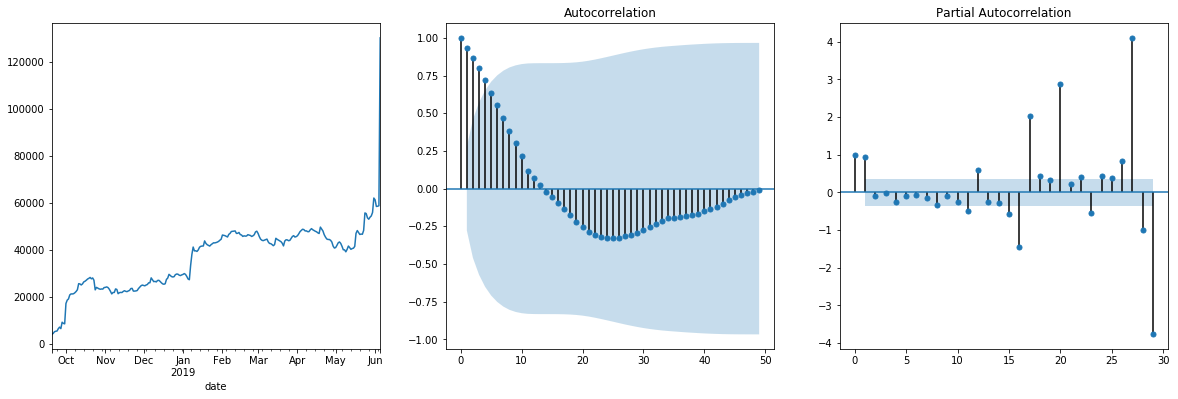

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
df.groupby('date').price.mean().plot(ax=ax[0])
_ = plot_acf(df.groupby('date').price.mean()[:50], ax=ax[1])
_ = plot_pacf(df.groupby('date').price.mean()[:30], ax=ax[2])

In [18]:
df_ = df[['date', 'resource_id', 'added_date', 'days', 'price']]

df_['price_day1'] = df.price.shift(1)
df_['price_day2'] = df.price.shift(2)
df_['price_day3'] = df.price.shift(3)
df_['price_day7'] = df.price.shift(7)
df_['price_day14'] = df.price.shift(14)
df_['price_day30'] = df.price.shift(30)

df['price_day0'] = df['price']
df['price_day1'] = np.where(df_.days == 1, 0, df_.price_day1)
df['price_day2'] = np.where(df_.days <= 2, 0, df_.price_day2)
df['price_day3'] = np.where(df_.days <= 3, 0, df_.price_day3)
df['price_day7'] = np.where(df_.days <= 7, 0, df_.price_day7)
df['price_day14'] = np.where(df_.days <= 14, 0, df_.price_day14)
df['price_day30'] = np.where(df_.days <= 30, 0, df_.price_day30)

**Target**:

Our target is the price of that player one week in advance, so we shift the variable. 

In [19]:
df['price_day0'] = df['price']         # rename the current price
df['y_price'] = df.price.shift(-7)

df = df[df.date <= df.date.max() - timedelta(7)]

## Drop

We don't need all the remaining columns, so we narrow down our projection before proceeding.

In [20]:
df.drop(['quality', 'revision', 'age', 'pace', 'pace_acceleration', 'pace_sprint_speed', 'drib_agility', 'drib_balance',
         'drib_reactions', 'drib_ball_control', 'drib_dribbling', 'shoot_positioning', 'shoot_finishing', 'shoot_shot_power',
         'shoot_long_shots', 'shoot_volleys', 'shoot_penalties', 'pass_vision', 'pass_crossing', 'pass_free_kick', 'pass_short',
         'pass_long', 'pass_curve', 'def_interceptions', 'def_heading', 'def_marking', 'def_stand_tackle', 'def_slid_tackle', 
         'phys_jumping', 'phys_strength', 'phys_aggression', 'pref_foot', 'num_games', 'price', 'added_date', 'position'], axis=1, inplace=True)

# Export

In [22]:
df.to_pickle('../data/ts_dataset.pkl')

# Modeling

In [25]:
# pipelines + training imports
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

# models
from sklearn.ensemble import RandomForestRegressor

In [76]:
df = pd.read_pickle('../data/ts_dataset.pkl')     # read the dataset

df = df[df.y_price!=0]                            # drop observations with 0 target (usually SBCs)

df.avg_goals.replace('-', 0, inplace=True)
df['avg_goals'] = pd.to_numeric(df.avg_goals)
df.avg_assists.replace('-', 0, inplace=True)
df['avg_assists'] = pd.to_numeric(df.avg_assists)

df.reset_index(drop=True, inplace=True)
df.head(2)

,player_name,overall,club,league,nationality,height,weight,intl_rep,dribbling,drib_composure,shooting,passing,defending,physicality,phys_stamina,att_workrate,def_workrate,weak_foot,skill_moves,resource_id,avg_goals,avg_assists,date,days,weekday,gen_pos,promo,source,available,days_release,price_day0,price_day1,price_day2,price_day3,price_day7,price_day14,price_day30,y_price
0,Ronaldo,94,1,1,1,187,83,5,90.0,95,93.0,81.0,35.0,79.0,88,High,Low,4,5,20801,0.92,0.37,2018-09-20,1,3,forward,0,base,1.0,0,1366667,0.0,0.0,0.0,0.0,0.0,0.0,1688245.0
1,Ronaldo,94,1,1,1,187,83,5,90.0,95,93.0,81.0,35.0,79.0,88,High,Low,4,5,20801,0.92,0.37,2018-09-21,2,4,forward,0,base,1.0,1,1322625,1366667.0,0.0,0.0,0.0,0.0,0.0,1774088.0


**Train/Test Split**:

In [77]:
test_size = 0.25
n_players = df.resource_id.nunique()
players = df.resource_id.unique()
players_test = np.random.choice(players, int(n_players*test_size))
players_train = np.array([x for x in players if x not in players_test])

In [78]:
print("""{} players in Training Set\n{} players in Test Set""".format(int(len(players_train)), int(len(players_test))))
print('{:2.2%} Split'.format(df[df.resource_id.isin(players_test)].shape[0] / df.shape[0]))

2853 players in Training Set
919 players in Test Set
21.89% Split


In [79]:
df_train = df[df.resource_id.isin(players_train)]
df_test = df[df.resource_id.isin(players_test)]

y_train = df_train.y_price
X_train = df_train.drop(['player_name', 'resource_id', 'date', 'y_price'], axis=1)

y_test = df_test.y_price
X_test = df_test.drop(['player_name', 'resource_id', 'date', 'y_price'], axis=1)

**Pipelines**:

In [80]:
cat_vars = ['club', 'league', 'nationality', 'att_workrate', 'def_workrate', 'gen_pos', 'promo', 'source', 'available']
num_vars = [x for x in X_train.columns if x not in cat_vars]

cat_mask = X_train.columns.isin(cat_vars); num_mask = X_train.columns.isin(num_vars)

In [89]:
# constructing our column transformer
ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False), cat_mask),
                             (StandardScaler(), ~cat_mask))


model = make_pipeline(ct, RandomForestRegressor(n_estimators=100, random_state=42))

In [90]:
param_grid = {'randomforestregressor__max_features': np.linspace(3, 8, 6).astype(int)}
gs = GridSearchCV(model, param_grid, n_jobs=2, cv=5, verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 